In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../data"))
# print(os.listdir("../input/glove-global-vectors-for-word-representation"))
# print(os.listdir("../input/jigsaw-unintended-bias-in-toxicity-classification"))

# Any results you write to the current directory are saved as output.

['all_data.csv', 'crawl-300d-2M.vec', 'glove.6B.100d.txt', 'glove.840B.300d.txt', 'identity_individual_annotations.csv', 'sample_submission.csv', 'test.csv', 'test_private_expanded.csv', 'test_public_expanded.csv', 'toxicity_individual_annotations.csv', 'train.csv']


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import os
import pandas as pd
import numpy as np
import pkg_resources
import seaborn as sns
import time
import scipy.stats as stats

from sklearn import metrics
from sklearn import model_selection

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model

In [156]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json

In [4]:
shap.initjs()
np.random.seed(0)

## Load and pre-process the data set

In [5]:
train = pd.read_csv('../data/train.csv')
print('loaded %d records' % len(train))

# Make sure all comment_text values are strings
train['comment_text'] = train['comment_text'].astype(str) 

# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

train = convert_dataframe_to_bool(train)

loaded 1804874 records


In [6]:
identity_columns_all = [
    'asian', 'atheist', 'bisexual',
    'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
    'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
    'jewish', 'latino', 'male', 'muslim', 'other_disability',
    'other_gender', 'other_race_or_ethnicity', 'other_religion',
    'other_sexual_orientation', 'physical_disability',
    'psychiatric_or_mental_illness', 'transgender', 'white'
]

In [7]:
identity_columns_race = [
    'asian', 'black', 'latino', 'other_race_or_ethnicity', 'white'
]

In [8]:
identity_columns_gender = [
    'female', 'male', 'other_gender', 'transgender'
]

In [9]:
identity_columns_sexuality = [
    'bisexual', 'heterosexual',
    'homosexual_gay_or_lesbian', 'other_sexual_orientation'
]

In [10]:
identity_columns_religion = [
    'atheist', 'buddhist', 'christian', 'hindu',
    'jewish', 'muslim', 'other_religion'
]

In [11]:
identity_columns_disability = [
    'intellectual_or_learning_disability', 'other_disability',
    'physical_disability', 'psychiatric_or_mental_illness'
]

In [12]:
train = train.sample(frac=0.1, random_state=0)

## Split the data into 80% train and 20% validate sets

In [13]:
train_df, validate_df = model_selection.train_test_split(train, test_size=0.2)
print('%d train comments, %d validate comments' % (len(train_df), len(validate_df)))


144389 train comments, 36098 validate comments


## Create a text tokenizer

In [14]:
MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 250
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

## Define and train a Convolutional Neural Net for classifying toxic comments

In [15]:
EMBEDDINGS_PATH = '../data/glove.6B.100d.txt'
EMBEDDINGS_DIMENSION = 100
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.00005
NUM_EPOCHS = 10
BATCH_SIZE = 128

def train_model(train_df, validate_df, tokenizer):
    # Prepare data
    train_text = pad_text(train_df[TEXT_COLUMN], tokenizer)
    train_labels = to_categorical(train_df[TOXICITY_COLUMN])
    validate_text = pad_text(validate_df[TEXT_COLUMN], tokenizer)
    validate_labels = to_categorical(validate_df[TOXICITY_COLUMN])

    # Load embeddings
    print('loading embeddings')
    embeddings_index = {}
    with open(EMBEDDINGS_PATH, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,
                                 EMBEDDINGS_DIMENSION))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # Create model layers.
    def get_convolutional_neural_net_layers():
        """Returns (input_layer, output_layer)"""
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                    EMBEDDINGS_DIMENSION,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
        x = embedding_layer(sequence_input)
        x = Conv1D(128, 2, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 3, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 4, activation='relu', padding='same')(x)
        x = MaxPooling1D(40, padding='same')(x)
        x = Flatten()(x)
        x = Dropout(DROPOUT_RATE)(x)
        x = Dense(128, activation='relu')(x)
        preds = Dense(2, activation='softmax')(x)
        return sequence_input, preds

    # Compile model.
    print('compiling model')
    input_layer, output_layer = get_convolutional_neural_net_layers()
    model = Model(input_layer, output_layer)
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=LEARNING_RATE),
                  metrics=['acc'])

    # Train model.
    print('training model')
    model.fit(train_text,
              train_labels,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_labels),
              verbose=2)

    return model

model = train_model(train_df, validate_df, tokenizer)

loading embeddings
compiling model


The `lr` argument is deprecated, use `learning_rate` instead.


training model
Epoch 1/10
1129/1129 - 68s - loss: 0.2861 - acc: 0.9132 - val_loss: 0.2527 - val_acc: 0.9180 - 68s/epoch - 61ms/step
Epoch 2/10
1129/1129 - 68s - loss: 0.2286 - acc: 0.9219 - val_loss: 0.2118 - val_acc: 0.9250 - 68s/epoch - 60ms/step
Epoch 3/10
1129/1129 - 66s - loss: 0.2060 - acc: 0.9270 - val_loss: 0.1983 - val_acc: 0.9301 - 66s/epoch - 59ms/step
Epoch 4/10
1129/1129 - 70s - loss: 0.1928 - acc: 0.9312 - val_loss: 0.1888 - val_acc: 0.9329 - 70s/epoch - 62ms/step
Epoch 5/10
1129/1129 - 70s - loss: 0.1845 - acc: 0.9342 - val_loss: 0.1878 - val_acc: 0.9348 - 70s/epoch - 62ms/step
Epoch 6/10
1129/1129 - 72s - loss: 0.1785 - acc: 0.9363 - val_loss: 0.1981 - val_acc: 0.9340 - 72s/epoch - 63ms/step
Epoch 7/10
1129/1129 - 83s - loss: 0.1737 - acc: 0.9377 - val_loss: 0.1805 - val_acc: 0.9367 - 83s/epoch - 74ms/step
Epoch 8/10
1129/1129 - 100s - loss: 0.1696 - acc: 0.9391 - val_loss: 0.1819 - val_acc: 0.9370 - 100s/epoch - 89ms/step
Epoch 9/10
1129/1129 - 93s - loss: 0.1658 - acc

## Generate model predictions on the validation set

In [16]:
MODEL_NAME = 'my_model'
validate_df[MODEL_NAME] = model.predict(pad_text(validate_df[TEXT_COLUMN], tokenizer))[:, 1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
validate_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,my_model
1228610,5616232,True,Hooray!!\n\nCelebrate destruction of periphera...,0.0,0.0,0.3,0.4,0.1,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,10,0.008176
1104931,5466504,False,"But according to Dems, WE'RE the ones spreadin...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,0,1,0.0,0,4,0.148744
307444,618691,False,The rot begins right at the top.,0.0,0.1,0.0,0.3,0.1,NaN,NaN,...,approved,0,0,0,90,0,0.0,0,10,0.138973
1620537,6106675,False,Joe & Mika are buddies with Weinstein. I reca...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,approved,0,0,0,0,0,0.0,0,4,0.028498
1508594,5967297,False,The irony is that many of the condemners are g...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,approved,2,0,0,5,0,0.0,5,4,0.304260


# Expanded AUC analysis

#### Define bias metrics, then evaluate our new model for bias using the validation set predictions

In [18]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def get_subgroup(df, subgroup):
        return df[subgroup] > df[subgroup].mean(skipna=True)

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[get_subgroup(df, subgroup)]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """
    Computes the AUC of the within-subgroup negative examples and the background positive examples.
    """
    subgroup_negative_examples = df[get_subgroup(df, subgroup) & ~df[label]]
    non_subgroup_positive_examples = df[~get_subgroup(df, subgroup) & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """
    Computes the AUC of the within-subgroup positive examples and the background negative examples.
    """
    subgroup_positive_examples = df[get_subgroup(df, subgroup) & df[label]]
    non_subgroup_negative_examples = df[~get_subgroup(df, subgroup) & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[get_subgroup(dataset, subgroup)])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

In [19]:
bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns_race, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
1,black,315,0.712222,0.721555,0.919953
4,white,534,0.727544,0.699009,0.935623
2,latino,130,0.834175,0.842410,0.910964
3,other_race_or_ethnicity,396,0.872887,0.845067,0.924579
0,asian,224,0.888643,0.884376,0.907158


In [20]:
bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns_gender, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
3,transgender,131,0.797850,0.829990,0.887930
2,other_gender,53,0.835859,0.849201,0.910740
1,male,873,0.840125,0.810353,0.924523
0,female,1052,0.847405,0.822584,0.920510


In [21]:
bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns_sexuality, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,227,0.742799,0.827514,0.856388
3,other_sexual_orientation,83,0.803172,0.835664,0.899335
0,bisexual,67,0.820513,0.829200,0.907636
1,heterosexual,74,0.872312,0.838912,0.924386


In [22]:
bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns_religion, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
5,muslim,447,0.836631,0.770282,0.944584
1,buddhist,34,0.843750,0.891908,0.839616
4,jewish,139,0.846364,0.825671,0.907569
0,atheist,46,0.858333,0.790448,0.952594
6,other_religion,322,0.874543,0.858259,0.920181
2,christian,805,0.879626,0.870789,0.911287
3,hindu,33,0.956790,0.854584,0.964462


In [23]:
bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns_disability, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
1,other_disability,59,0.795918,0.859577,0.848172
3,psychiatric_or_mental_illness,98,0.850788,0.904407,0.852128
2,physical_disability,59,0.877451,0.889491,0.892723
0,intellectual_or_learning_disability,49,0.931373,0.901631,0.926053


## SHAP

In [24]:
## Convert text to padded tokenized vectors
train_text = pad_text(train_df[TEXT_COLUMN], tokenizer)
val_text = pad_text(validate_df[TEXT_COLUMN], tokenizer)

## Token mappings
num_to_word = tokenizer.index_word
num_to_word[0] = ""

In [49]:
val_text

array([[   0,    0,    0, ...,  365, 6341,   15],
       [   0,    0,    0, ...,  564, 4040,  438],
       [   0,    0,    0, ...,   35,    1,  554],
       ...,
       [   0,    0,    0, ..., 1109,  607,  801],
       [   0,    0,    0, ...,    9,   91,  419],
       [   0,    0,    0, ...,   35, 1356, 1908]])

In [25]:
def preds_for_shap(text_array):
    return model.predict(text_array)[:, 1]

In [26]:
# Initialize the explainer and apply to test data
explainer = shap.KernelExplainer(preds_for_shap, shap.sample(train_text, 100))


In [27]:
def make_force_plot(doc_idx, text_array=val_text, explainer=explainer, token_maps=num_to_word):
    doc = text_array[doc_idx]
    shap_values = explainer.shap_values(doc).reshape(-1)
    
    sent_start = 250 - (doc > 0).sum()
    
    names = [token_maps[i] for i in doc.tolist()]
    
    to_plot = shap.force_plot(
        explainer.expected_value, shap_values[sent_start:], doc[sent_start:],
        feature_names=names[sent_start:], matplotlib=True
    )
    
    return to_plot

In [145]:
def get_shap_vals(text_array=val_text, explainer=explainer, token_maps=num_to_word):
    word_values = defaultdict(list)
    word_count_pos = defaultdict(int)
    word_count_neg = defaultdict(int)
    
    for doc in text_array:
        sent_start = 250 - (doc > 0).sum()
        shap_values = explainer.shap_values(doc).reshape(-1)[sent_start:]
        names = [token_maps[i] for i in doc.tolist()][sent_start:]
        
        for i in range(len(shap_values)):
            word_values[names[i]].append(shap_values[i])
            if shap_values[i] > 0:
                word_count_pos[names[i]] += 1
            else:
                word_count_neg[names[i]] += 1
                
    return word_values, word_count_pos, word_count_neg

In [168]:
## For Black-related comments
comment_subset = shap.sample(val_text[validate_df.black.values], 150)
word_values_b, word_count_pos_b, word_count_neg_b = get_shap_vals(comment_subset)

with open("../output/black_word_values.json", "w") as outfile:
    json.dump(word_values_b, outfile)
with open("../output/black_word_pos.json", "w") as outfile:
    json.dump(word_count_pos_b, outfile)
with open("../output/black_word_neg.json", "w") as outfile:
    json.dump(word_count_neg_b, outfile)

In [169]:
## For White-related comments
comment_subset = shap.sample(val_text[validate_df.white.values], 150)
word_values_w, word_count_pos_w, word_count_neg_w = get_shap_vals(comment_subset)

with open("../output/white_word_values.json", "w") as outfile:
    json.dump(word_values_w, outfile)
with open("../output/white_word_pos.json", "w") as outfile:
    json.dump(word_count_pos_w, outfile)
with open("../output/white_word_neg.json", "w") as outfile:
    json.dump(word_count_neg_w, outfile)

In [240]:
## Aggregate data for each group
shap_agg_b = pd.DataFrame(columns=["token", "shap_mean", "shap_std", "pos_count", "neg_count"])
idx = 0

for word in word_values_b.keys():
    to_add = pd.DataFrame({
        "token":word,
        "shap_mean":np.mean(word_values_b[word]),
        "shap_std":np.std(word_values_b[word]),
        "pos_count":word_count_pos_b[word],
        "neg_count":word_count_neg_b[word]},
        index=[idx]
    )
    
    shap_agg_b = pd.concat([shap_agg_b, to_add])
    idx+=1
shap_agg_b.sort_values("shap_mean", ascending=False, inplace=True)
shap_agg_b.reset_index(drop=True, inplace=True)
    
shap_agg_w = pd.DataFrame(columns=["token", "shap_mean", "shap_std", "pos_count", "neg_count"])
idx = 0

for word in word_values_w.keys():
    to_add = pd.DataFrame({
        "token":word,
        "shap_mean":np.mean(word_values_w[word]),
        "shap_std":np.std(word_values_w[word]),
        "pos_count":word_count_pos_w[word],
        "neg_count":word_count_neg_w[word]},
        index=[idx]
    )
    
    shap_agg_w = pd.concat([shap_agg_w, to_add])
    idx+=1
shap_agg_w.sort_values("shap_mean", ascending=False, inplace=True)
shap_agg_w.reset_index(drop=True, inplace=True)

In [299]:
perc_10_b = np.percentile(shap_agg_b.pos_count + shap_agg_b.neg_count, 90)
freq_b = shap_agg_b[shap_agg_b.pos_count + shap_agg_b.neg_count > perc_10_b]
pos_tokens_b = freq_b.token.head(5).to_list()
neg_tokens_b = freq_b.token.tail(5).to_list()
tokens_b = pos_tokens_b + neg_tokens_b

perc_10_w = np.percentile(shap_agg_w.pos_count + shap_agg_w.neg_count, 90)
freq_w = shap_agg_w[shap_agg_w.pos_count + shap_agg_w.neg_count > perc_10_w]
pos_tokens_w = freq_w.token.head(5).to_list()
neg_tokens_w = freq_w.token.tail(5).to_list()
tokens_w = pos_tokens_w + neg_tokens_w

In [ ]:
## All words

In [315]:
shap_agg_b.iloc[np.r_[0:5, -5:0]]

,token,shap_mean,shap_std,pos_count,neg_count
0,idiot,0.656609,0.012035,4,0
1,stupid,0.517934,0.000000,1,0
2,crap,0.390789,0.000000,1,0
3,bigot,0.213302,0.000000,1,0
4,irresponsible,0.184091,0.000000,1,0
2213,trailer,-0.035634,0.000000,0,1
2214,skewed,-0.037295,0.000000,0,1
2215,immigration,-0.041773,0.000000,0,1
2216,text,-0.050299,0.000000,0,1
2217,wp,-0.060444,0.000405,0,2


In [316]:
shap_agg_b.iloc[np.r_[0:5, -5:0]].to_latex("../output/shap_black.tex")

In [310]:
shap_agg_w.iloc[np.r_[0:5, -5:0]]

,token,shap_mean,shap_std,pos_count,neg_count
0,shit,0.359153,0.000000,1,0
1,bigot,0.182565,0.023506,2,0
2,dumb,0.169451,0.000000,1,0
3,spineless,0.168221,0.000000,1,0
4,crazy,0.163414,0.003105,2,0
2354,deleted,-0.044967,0.000000,0,1
2355,funny,-0.048490,0.008651,0,2
2356,wikipedia,-0.051707,0.000000,0,1
2357,village,-0.052740,0.000000,0,1
2358,duh,-0.092301,0.000000,0,1


In [317]:
shap_agg_w.iloc[np.r_[0:5, -5:0]].to_latex("../output/shap_white.tex")

In [ ]:
## Top 10 percentile of frequency of use

In [312]:
freq_b.iloc[np.r_[0:5, -5:0]]

,token,shap_mean,shap_std,pos_count,neg_count
38,racist,0.046228,0.024620,21,0
39,black,0.044818,0.037996,191,2
45,cops,0.042554,0.022657,10,0
60,guy,0.034466,0.021638,10,0
70,white,0.029545,0.022709,101,4
1885,professor,-0.004356,0.005762,0,9
1897,against,-0.004505,0.008147,3,26
1899,point,-0.004546,0.005724,0,9
1930,house,-0.005107,0.004528,0,9
1978,players,-0.006255,0.008457,1,11


In [318]:
freq_b.iloc[np.r_[0:5, -5:0]].to_latex("../output/shap_black_perc10.tex")

In [313]:
freq_w.iloc[np.r_[0:5, -5:0]]

,token,shap_mean,shap_std,pos_count,neg_count
44,racist,0.042397,0.031593,22,0
51,black,0.036626,0.028203,37,2
52,white,0.036239,0.029082,181,4
63,supremacists,0.031421,0.019892,15,0
82,women,0.024868,0.021751,16,1
2022,also,-0.005441,0.008518,0,14
2058,population,-0.005863,0.010016,0,16
2095,which,-0.006734,0.007501,1,12
2227,comment,-0.011282,0.015161,0,10
2310,farm,-0.019280,0.014994,0,8


In [319]:
freq_w.iloc[np.r_[0:5, -5:0]].to_latex("../output/shap_white_perc10.tex")

In [300]:
## Prep data for plotting
plot_data_b = []
for word in tokens_b:
    plot_data_b.append(word_values_b[word])

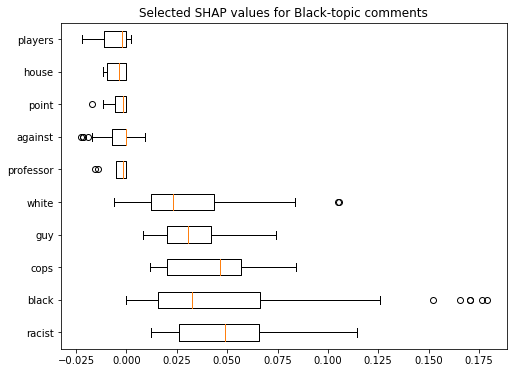

In [304]:
## Plot for each group
plt.figure(figsize=[8,6])
plt.boxplot(plot_data_b, vert=False)
plt.yticks(np.arange(1, 11), tokens_b)
plt.title("Selected SHAP values for Black-topic comments")
plt.show()

In [302]:
## Prep data for plotting
plot_data_w = []
for word in tokens_w:
    plot_data_w.append(word_values_w[word])

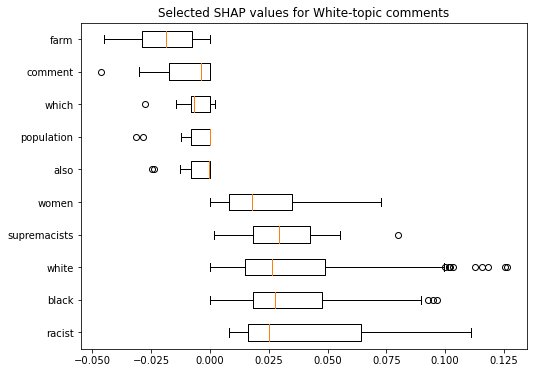

In [305]:
## Plot for each group
plt.figure(figsize=[8,6])
plt.boxplot(plot_data_w, vert=False)
plt.yticks(np.arange(1, 11), tokens_w)
plt.title("Selected SHAP values for White-topic comments")
plt.show()

In [51]:
find_docs = validate_df.copy()
find_docs.reset_index(drop=True, inplace=True)
find_docs["pred"] = find_docs.my_model > 0.5

# White (True positive)

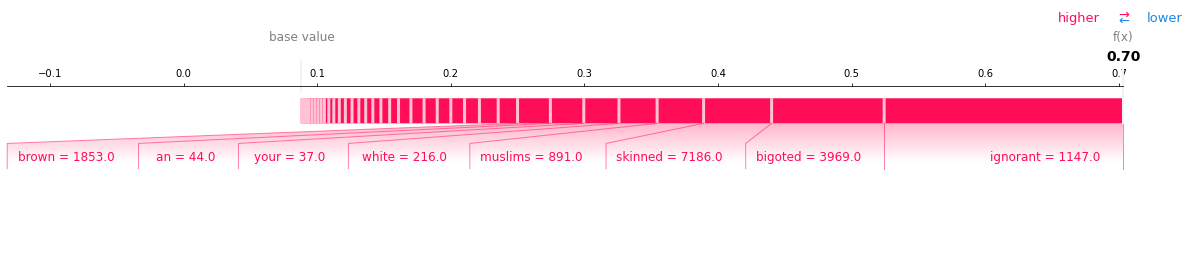

In [101]:
make_force_plot(1952)

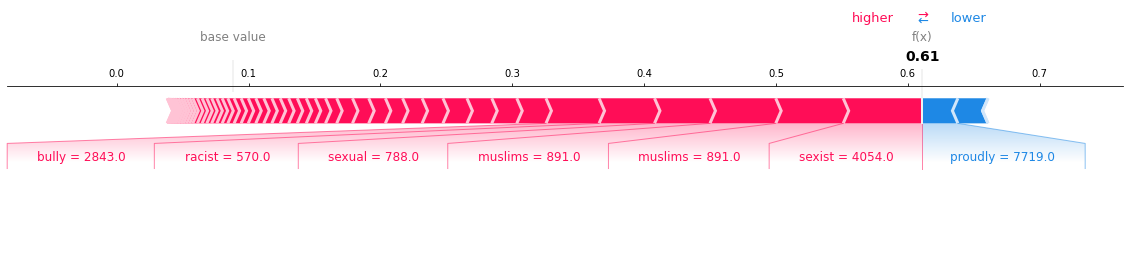

In [102]:
make_force_plot(5243)

# White (True negative)

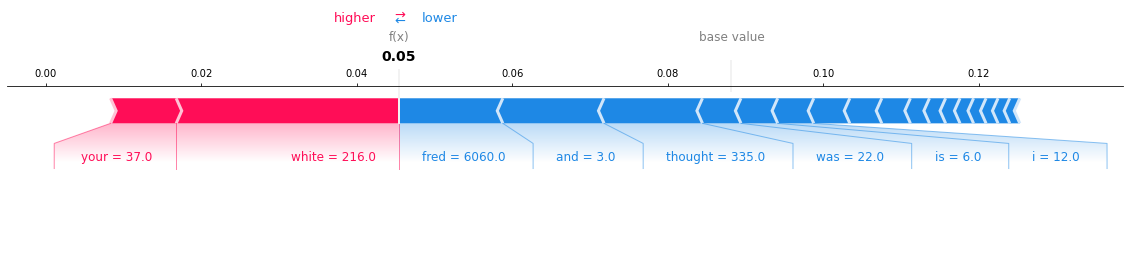

In [104]:
make_force_plot(35676)

# White (False negative)

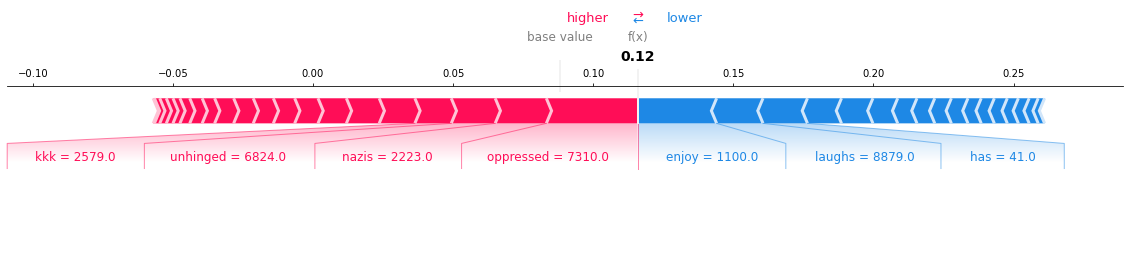

In [97]:
make_force_plot(4887)

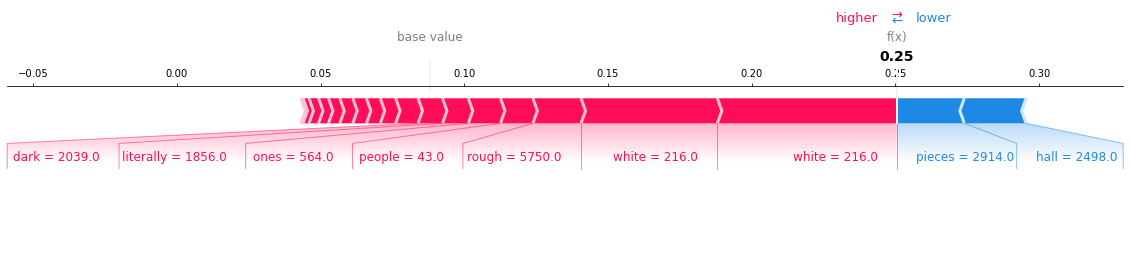

In [98]:
make_force_plot(4878)

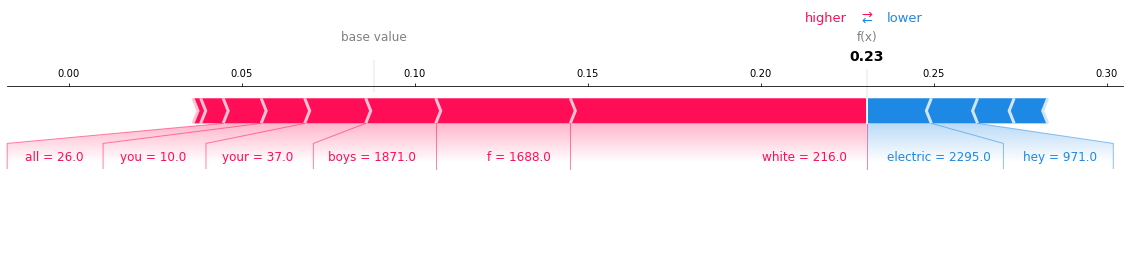

In [99]:
make_force_plot(5358)

# White (False positives)

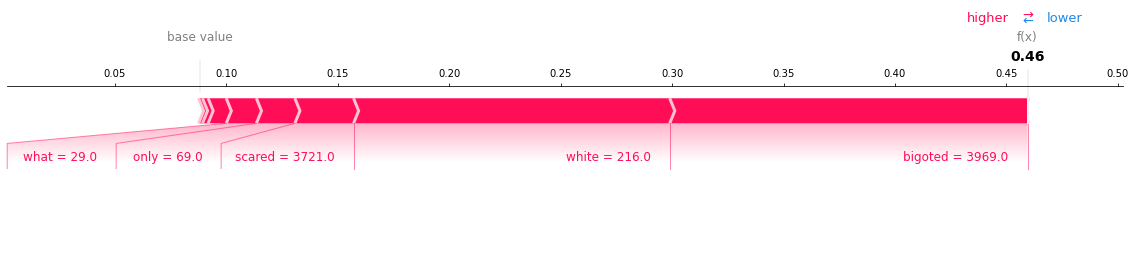

In [63]:
make_force_plot(295)

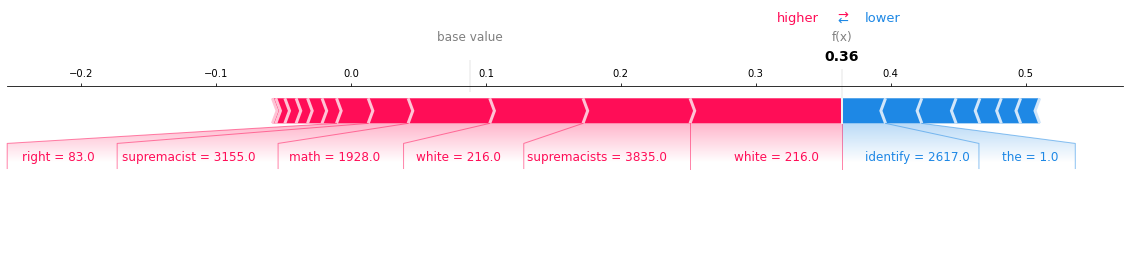

In [64]:
make_force_plot(1402)

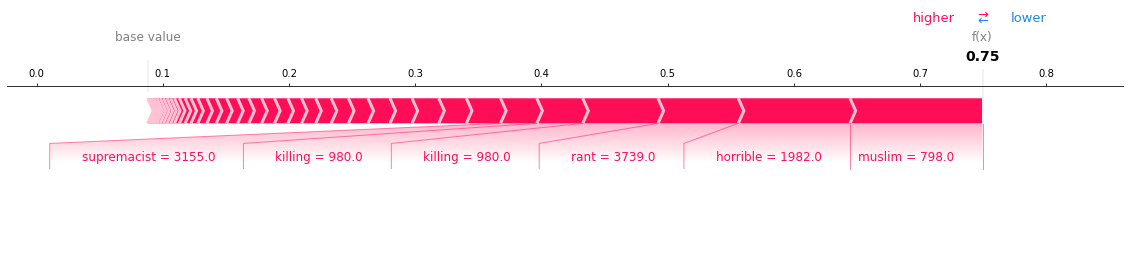

In [65]:
make_force_plot(2854)

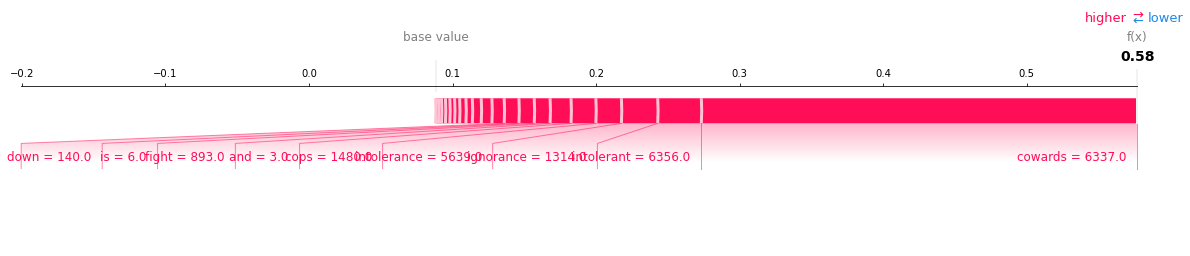

In [66]:
make_force_plot(3042)

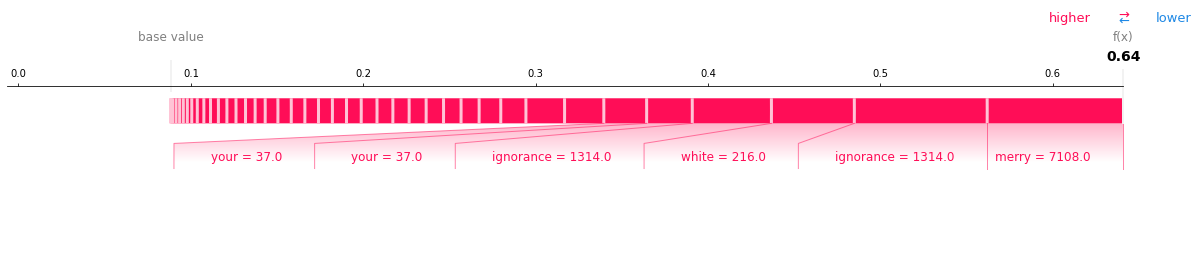

In [67]:
make_force_plot(3399)

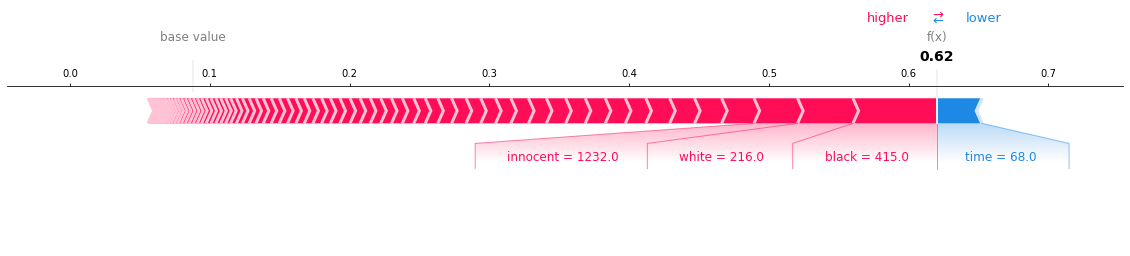

In [68]:
make_force_plot(3612)

---

# Black (true positives)

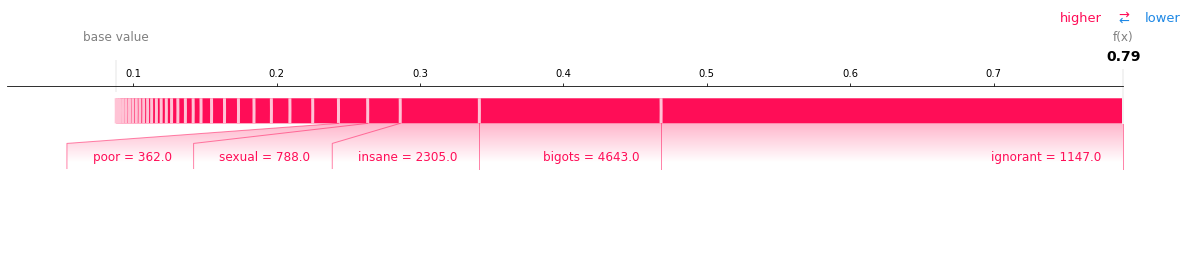

In [87]:
make_force_plot(3929)

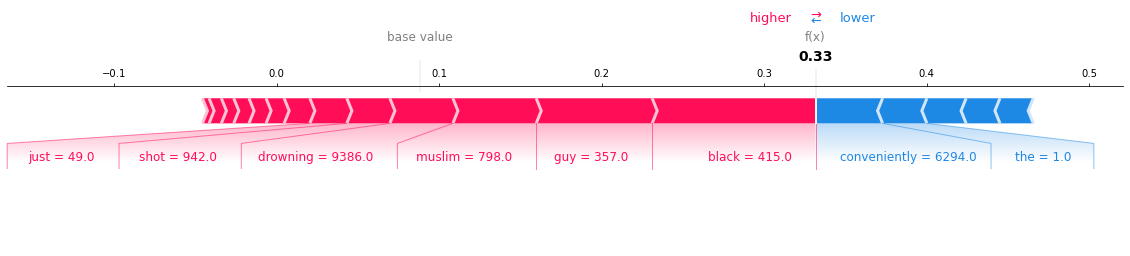

In [90]:
make_force_plot(3969)

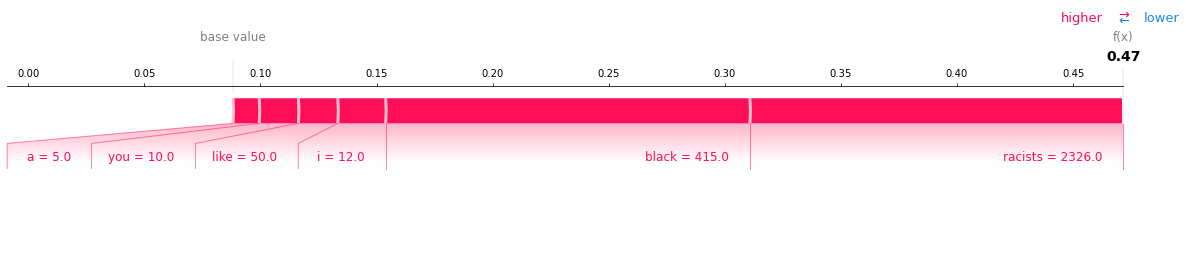

In [91]:
make_force_plot(11095)

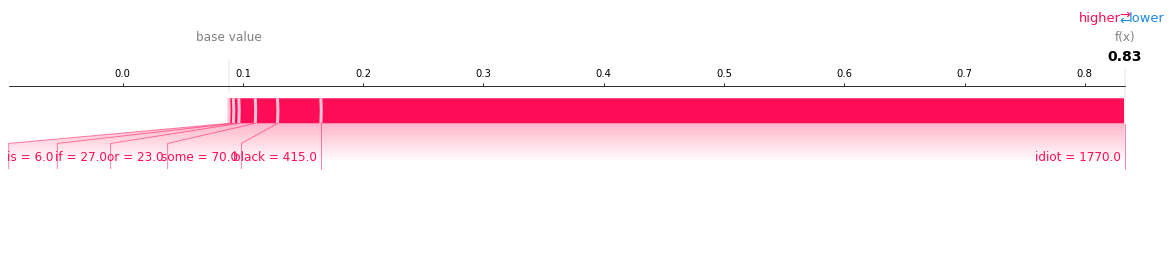

In [92]:
make_force_plot(4923)

# Black (true negatives)

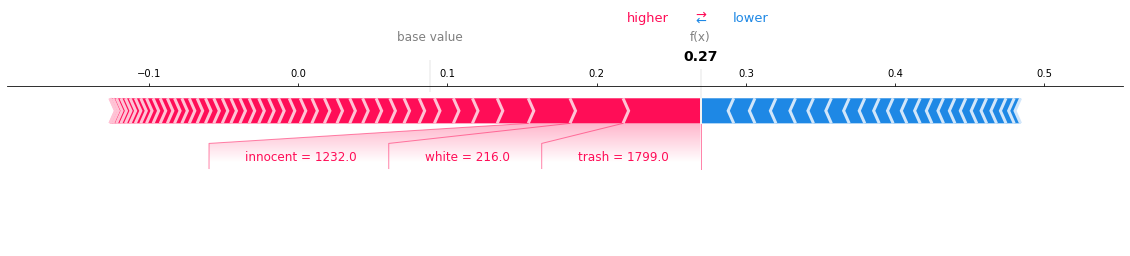

In [94]:
make_force_plot(3145)

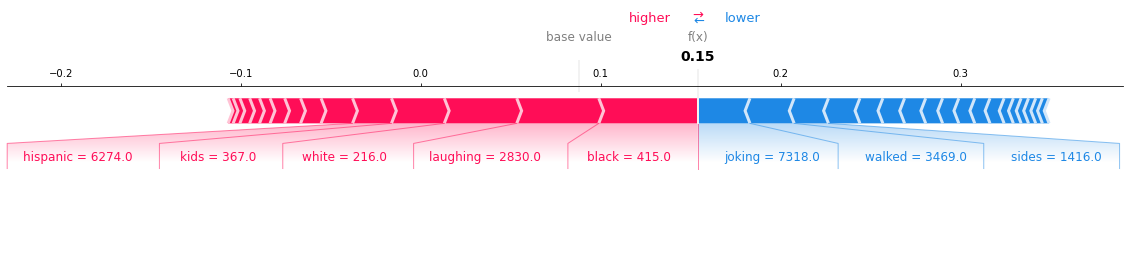

In [95]:
make_force_plot(4320)

# Black (False positives)

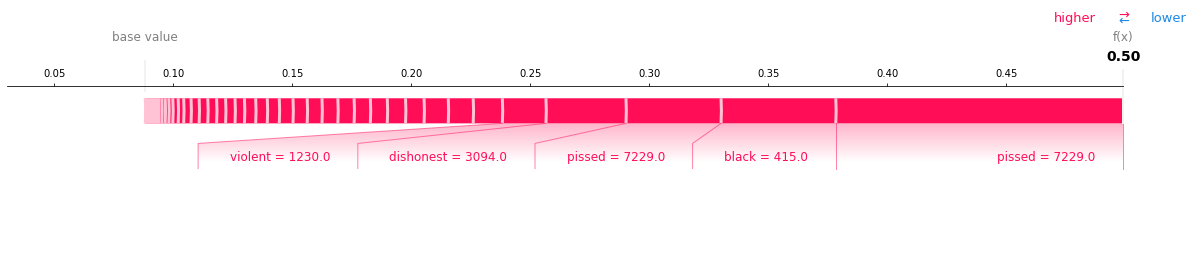

In [69]:
make_force_plot(8729)

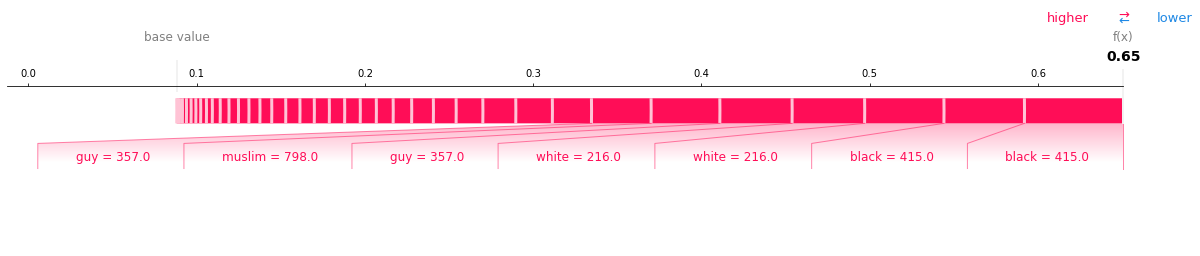

In [70]:
make_force_plot(8779)

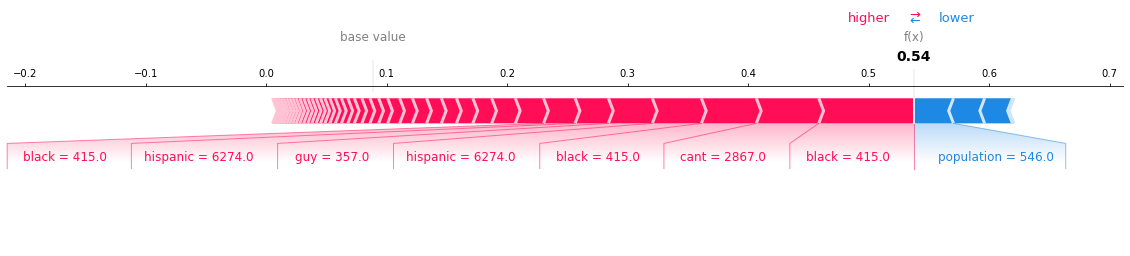

In [71]:
make_force_plot(12310)

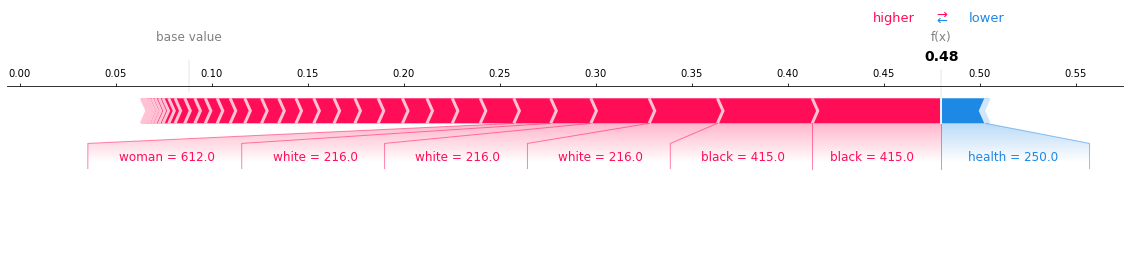

In [72]:
make_force_plot(25451)

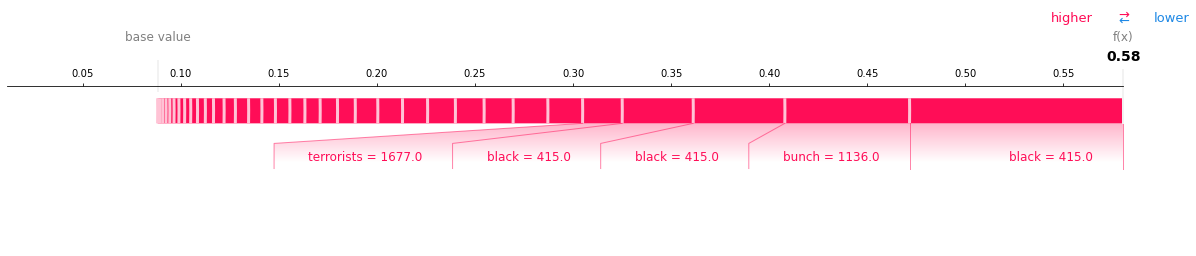

In [73]:
make_force_plot(28303)

In [326]:
find_docs.loc[30121].comment_text

"It's pretty black and white, convicted and known terrorist who killed people gets paid $10.5M for it."

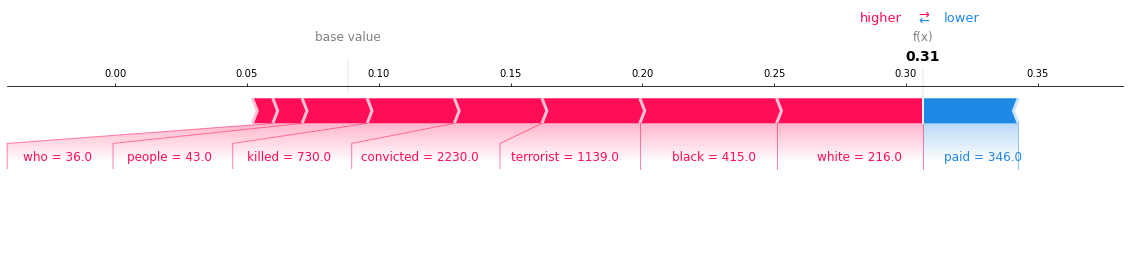

In [74]:
make_force_plot(30121)

# Black (false negatives)

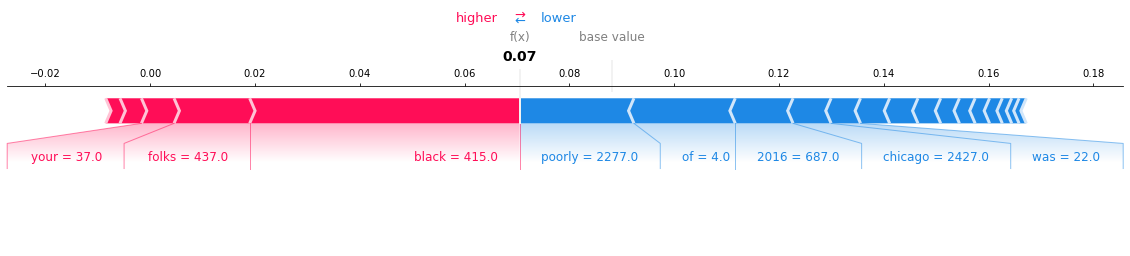

In [79]:
make_force_plot(35931)

In [331]:
find_docs.loc[2563].comment_text

"Poverty increased, food stamp increases, debts and deficits increased greatly, black killing blacks increased exponentially in certain areas, auto debt record highs, student debt record highs, Middle East conflict never stopped. The saddest part is he got a peace prize for jack sh&&. That's obama basically."

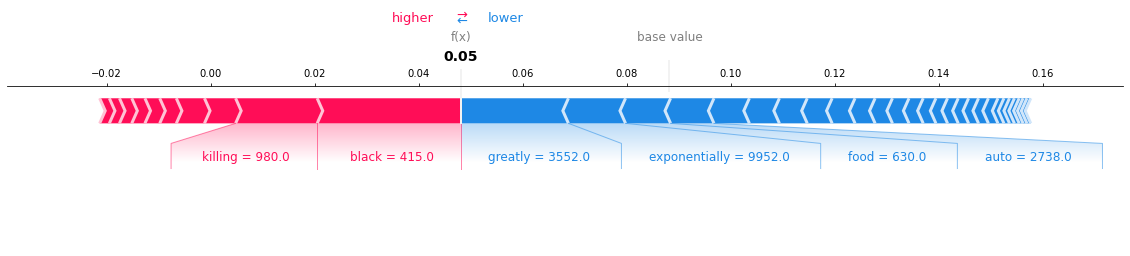

In [83]:
make_force_plot(2563)

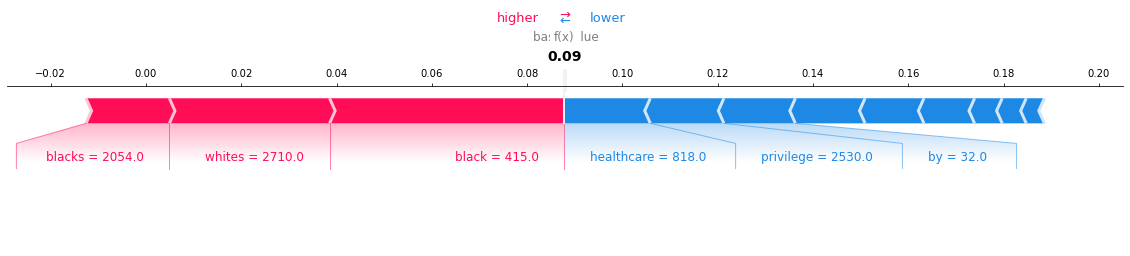

In [84]:
make_force_plot(3490)

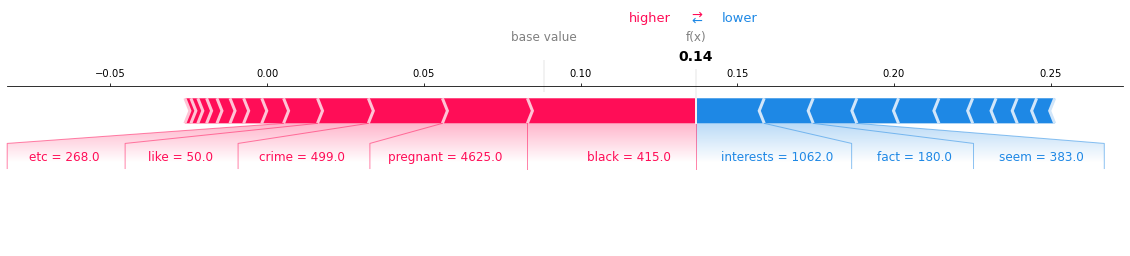

In [85]:
make_force_plot(5918)

## Calculate the final score

In [14]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))

nan

## Prediction on Test data

In [47]:
test = pd.read_csv('../data/test.csv', nrows=100)
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

In [22]:
#submission['prediction'] = model.predict(pad_text(test[TEXT_COLUMN], tokenizer))[:, 1]
# submission.to_csv('submission.csv')

In [56]:
## temp
preds = model.predict(pad_text(test[TEXT_COLUMN], tokenizer))[:, 1]
preds

array([7.15577230e-03, 4.90104556e-02, 1.02635235e-01, 1.84325818e-02,
       3.31334048e-03, 2.29058811e-03, 9.19009745e-01, 4.33479935e-01,
       7.41865113e-03, 1.17096249e-02, 2.42425911e-02, 8.65507033e-03,
       8.00151099e-03, 4.27603833e-02, 1.29632587e-02, 1.67573411e-02,
       3.59107196e-01, 3.42571759e-03, 8.11406318e-03, 3.01692903e-01,
       1.18248658e-02, 5.11380732e-02, 1.95065141e-03, 3.04219383e-03,
       6.58857916e-03, 7.51316920e-03, 3.14437807e-01, 3.11113298e-02,
       7.16009038e-03, 6.17655646e-03, 7.19938893e-03, 5.88304829e-03,
       7.68345082e-03, 3.36692512e-01, 1.99838802e-01, 8.28171194e-01,
       3.26740593e-01, 2.66080089e-02, 4.12022602e-03, 2.77639297e-03,
       5.56573551e-03, 1.21836491e-01, 2.31387443e-03, 8.61264393e-02,
       1.05035084e-03, 7.94345979e-03, 3.65556143e-02, 1.18834056e-01,
       3.71191604e-03, 8.07330571e-03, 1.68342814e-02, 3.23550254e-01,
       1.09476233e-02, 2.34809774e-03, 2.24931445e-02, 1.77595578e-02,
      